<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Chess Game Playing While Chitchatting by GPT-4 Agents

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is modified based on https://github.com/ekzhu/FLAML/blob/evaluation/evaluation/chess/play_chess.ipynb

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
%%capture --no-stderr
# %pip install "pyautogen~=0.2.0b4"
%pip install chess -U

In [2]:
import chess
import chess.svg

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [3]:
import autogen

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)
# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": {
#             "gpt-3.5-turbo",
#             "gpt-3.5-turbo-16k",
#             "gpt-3.5-turbo-16k-0613",
#             "gpt-3.5-turbo-0301",
#             "chatgpt-35-turbo-0301",
#             "gpt-35-turbo-v0301",
#         },
#     },
# )

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Define Agents

We'll define a BoardAgent and a ChessPlayerAgent class.

In [4]:
from collections import defaultdict
from typing import Any, Dict, List, Optional, Union

sys_msg = """You are an AI-powered chess board agent.
You translate the user's natural language input into legal UCI moves.
You should only reply with a UCI move string extracted from the user's input."""

class BoardAgent(autogen.AssistantAgent):
    board: chess.Board
    correct_move_messages: Dict[autogen.Agent, List[Dict]]

    def __init__(self, board: chess.Board):
        super().__init__(
            name="BoardAgent",
            system_message=sys_msg,
            llm_config={"temperature": 0.0, "config_list": config_list_gpt4},
            max_consecutive_auto_reply=10,
        )
        self.register_reply(autogen.ConversableAgent, BoardAgent._generate_board_reply)
        self.board = board
        self.correct_move_messages = defaultdict(list)

    def _generate_board_reply(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[Any] = None,
    ) -> Union[str, Dict, None]:
        message = messages[-1]
        # extract a UCI move from player's message
        reply = self.generate_reply(self.correct_move_messages[sender] + [message], sender, exclude=[BoardAgent._generate_board_reply])
        uci_move = reply if isinstance(reply, str) else str(reply["content"])
        try:
            self.board.push_uci(uci_move)
        except ValueError as e:
            # invalid move
            return True, f"Error: {e}"
        else:
            # valid move
            m = chess.Move.from_uci(uci_move)
            display(chess.svg.board(self.board, arrows=[(m.from_square, m.to_square)], fill={m.from_square: "gray"}, size=200))
            self.correct_move_messages[sender].extend([message, self._message_to_dict(uci_move)])
            self.correct_move_messages[sender][-1]["role"] = "assistant"
            return True, uci_move


In [5]:
sys_msg_tmpl = """Your name is {name} and you are a chess player. 
You are playing against {opponent_name}. 
You are playing as {color}. 
You communicate your move using universal chess interface language.
You also chit-chat with your opponent when you communicate a move to light up the mood.
You should ensure both you and the opponent are making legal moves.
Do not apologize for making illegal moves."""


class ChessPlayerAgent(autogen.AssistantAgent):

    def __init__(
        self,
        color: str,
        board_agent: BoardAgent,
        max_turns: int,
        **kwargs,
    ):
        if color not in ["white", "black"]:
            raise ValueError(f"color must be either white or black, but got {color}")
        opponent_color = "black" if color == "white" else "white"
        name = f"Player {color}"
        opponent_name = f"Player {opponent_color}"
        sys_msg = sys_msg_tmpl.format(
            name=name,
            opponent_name=opponent_name,
            color=color,
        )
        super().__init__(
            name=name,
            system_message=sys_msg,
            max_consecutive_auto_reply=max_turns,
            **kwargs,
        )
        self.register_reply(BoardAgent, ChessPlayerAgent._generate_reply_for_board, config=board_agent.board)
        self.register_reply(ChessPlayerAgent, ChessPlayerAgent._generate_reply_for_player, config=board_agent)
        self.update_max_consecutive_auto_reply(board_agent.max_consecutive_auto_reply(), board_agent)

    def _generate_reply_for_board(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[chess.Board] = None,
    ) -> Union[str, Dict, None]:
        board = config
        # add a system message about the current state of the board.
        board_state_msg = [{"role": "system", "content": f"Current board:\n{board}"}]
        last_message = messages[-1]
        if last_message["content"].startswith("Error"):
            # try again
            last_message["role"] = "system"
            return True, self.generate_reply(messages + board_state_msg, sender, exclude=[ChessPlayerAgent._generate_reply_for_board])
        else:
            return True, None

    def _generate_reply_for_player(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[BoardAgent] = None,
    ) -> Union[str, Dict, None]:
        board_agent = config
        # add a system message about the current state of the board.
        board_state_msg = [{"role": "system", "content": f"Current board:\n{board_agent.board}"}]
        # propose a reply which will be sent to the board agent for verification.
        message = self.generate_reply(messages + board_state_msg, sender, exclude=[ChessPlayerAgent._generate_reply_for_player])
        if message is None:
            return True, None
        # converse with the board until a legal move is made or max allowed retries.
        # change silent to False to see that conversation.
        self.initiate_chat(board_agent, clear_history=False, message=message, silent=self.human_input_mode == "NEVER")
        # last message sent by the board agent
        last_message = self._oai_messages[board_agent][-1]
        if last_message["role"] == "assistant":
            # didn't make a legal move after a limit times of retries.
            print(f"{self.name}: I yield.")
            return True, None
        return True, self._oai_messages[board_agent][-2]


## Construct Agents

In [6]:
max_turn = 10

board = chess.Board()
board_agent = BoardAgent(board=board)
player_black = ChessPlayerAgent(
    color="black",
    board_agent=board_agent,
    max_turns=max_turn,
    llm_config={"temperature": 0.5, "cache_seed": 1, "config_list": config_list_gpt4},
)
player_white = ChessPlayerAgent(
    color="white",
    board_agent=board_agent,
    max_turns=max_turn,
    llm_config={"temperature": 0.5, "cache_seed": 2, "config_list": config_list_gpt4},
)

## Start Game

Player black (to Player white):

Your turn.

--------------------------------------------------------------------------------


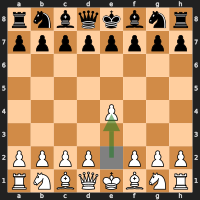

Player white (to Player black):

Alright, let's kick things off. I'll move my pawn from e2 to e4. The center of the board is the heart of the battle, isn't it? Your move. 

e2e4

--------------------------------------------------------------------------------


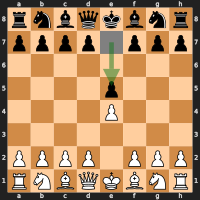

Player black (to Player white):

Ah, the King's Pawn Opening, a classic. Let's see how this plays out. I'll move my pawn from e7 to e5. 

e7e5

You know, I've always admired how chess reflects life. It's all about making strategic decisions, isn't it? Your move.

--------------------------------------------------------------------------------


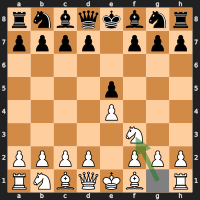

Player white (to Player black):

Indeed, chess is a mirror of life in many ways. Every move matters, just like every decision in life. I'll move my knight from g1 to f3, aiming to control the center.

g1f3

--------------------------------------------------------------------------------


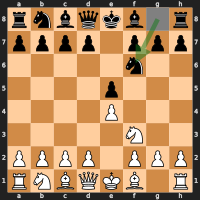

Player black (to Player white):

Well said! Chess is indeed a game of deep strategy and foresight. I will move my knight from g8 to f6, matching your control of the center.

g8f6

Did you know, the knight's move is actually based on the 'L' shape, which stands for 'leap'? Quite interesting, isn't it? Your move.

--------------------------------------------------------------------------------


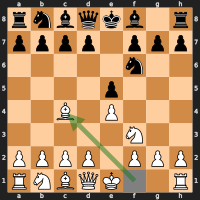

Player white (to Player black):

That's a fun fact! The knight's L-shaped leap makes it a unique piece on the board. Now, I'll move my bishop from f1 to c4, putting a little pressure on your side.

f1c4

--------------------------------------------------------------------------------


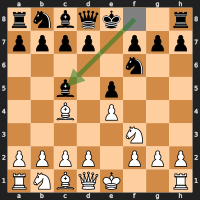

Player black (to Player white):

A strong move, indeed! I can see you're not one to hold back. I'll move my bishop from f8 to c5, maintaining the balance.

f8c5

You know, the bishop was originally an elephant in ancient chess. It's fascinating how the game has evolved over the centuries, isn't it? Your move.

--------------------------------------------------------------------------------


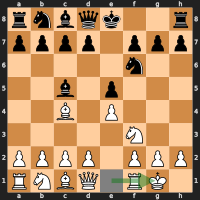

Player white (to Player black):

Absolutely, the evolution of chess is quite fascinating. It's a testament to the game's timeless appeal. Now, I'll castle kingside to ensure my king's safety. 

e1g1

--------------------------------------------------------------------------------


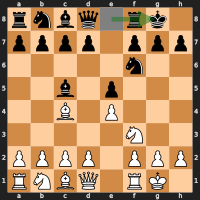

Player black (to Player white):

A wise decision, safety first! I'll follow your lead and castle kingside as well. 

e8g8

They say the king is a fighting piece, but in the early game, it's all about keeping him safe, isn't it? Your move.

--------------------------------------------------------------------------------


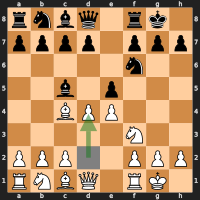

Player white (to Player black):

I see, it looks like we had a bit of a mix-up. Let's get back to the game. I'll move my pawn from d2 to d4, opening up lines for my queen and bishop.

d2d4

--------------------------------------------------------------------------------


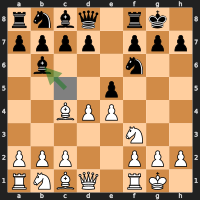

Player black (to Player white):

Indeed, opening lines for your major pieces is a crucial part of the game. I'll move my bishop from c5 to b6. 

c5b6

Chess is a lot like a dance, don't you think? Each piece moving in harmony with the others. Your move.

--------------------------------------------------------------------------------


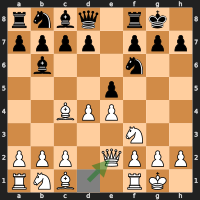

Player white (to Player black):

I see, it looks like we had a bit of a mix-up. Let's get back to the game. I'll move my queen from d1 to e2, aiming to control the center.

d1e2

--------------------------------------------------------------------------------


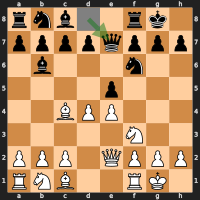

Player black (to Player white):

Indeed, control of the center is key. I'll move my queen from d8 to e7, matching your control of the center.

d8e7

Did you know the queen wasn't always the most powerful piece on the board? In the original game of chess, the piece could only move one square diagonally! Your move.

--------------------------------------------------------------------------------


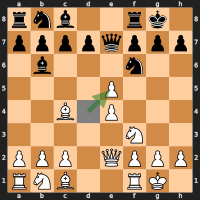

Player white (to Player black):

Indeed, the queen has come a long way from its humble beginnings. Now, I'll move my pawn from d4 to e5, adding some tension to the center.

d4e5

--------------------------------------------------------------------------------


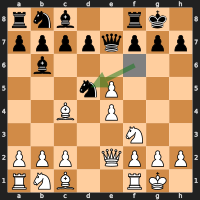

Player black (to Player white):

Interesting move! This is shaping up to be quite the game. I'll move my knight from f6 to d5.

f6d5

You know, the knight is the only piece that can jump over others. It's like the horse in a game of polo, leaping over obstacles. Your move.

--------------------------------------------------------------------------------


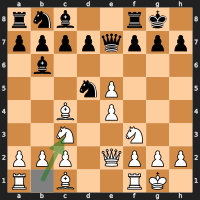

Player white (to Player black):

Indeed, the knight's ability to jump over other pieces is quite unique. Now, I'll move my knight from b1 to c3, challenging your knight.

b1c3

--------------------------------------------------------------------------------


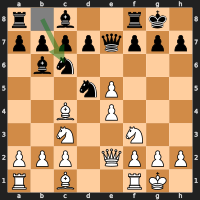

Player black (to Player white):

Apologies for the confusion. It seems there was a misunderstanding. I'll correct that and move my knight from b8 to c6.

b8c6

Did you know that in the Middle Ages, the knight piece was usually carved to resemble a horse's head? Your move.

--------------------------------------------------------------------------------


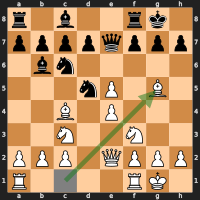

Player white (to Player black):

That's a fascinating bit of history! The knight piece's design certainly adds to the charm of the game. Now, I'll move my bishop from c1 to g5, putting a little pressure on your queen.

c1g5

--------------------------------------------------------------------------------


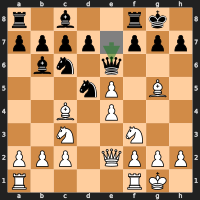

Player black (to Player white):

Well played! I see you're not one to shy away from a challenge. I'll move my queen from e7 to e6, keeping her safe.

e7e6

Did you know that the queen's ability to move any number of squares along a rank, file, or diagonal is a relatively recent development in the history of chess? Your move.

--------------------------------------------------------------------------------


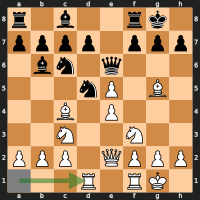

Player white (to Player black):

Indeed, the queen's powers were significantly enhanced during the Middle Ages, transforming the game of chess. Now, I'll move my rook from a1 to d1, aligning it with your queen.

a1d1

--------------------------------------------------------------------------------


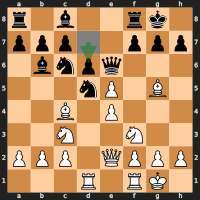

Player black (to Player white):

My apologies for the confusion. Let's correct that. I'll move my pawn from d7 to d6.

d7d6

Did you know that pawns are the soul of chess? It's fascinating how these seemingly insignificant pieces can control the fate of the game. Your move.

--------------------------------------------------------------------------------


In [7]:
player_black.initiate_chat(player_white, message="Your turn.")